In [16]:
# Compile Data
# 1 sample = 100x15 data, where 100 is the number of time points and 15 is the number of features
# 15 features: 8 EMG, 3 accelerometer, 3 gyroscope + 1 label that gets added from the filename

import os
import numpy as np
import pandas as pd
import glob

PATH = '../data/'

CLASSES = {'idle':0, 'kick':1, 'pass':2, 'walk':3}
REVERSE_CLASSES = {0:'idle', 1:'kick', 2:'pass', 3:'walk'}  

def get_data(filepath):
    """
    Get data from the given path, and return a numpy array of shape (100, 15)
    :param path: path to the data file
    :return: numpy array of shape (100, 15)
    """
    # Read the data file
    df = pd.read_csv(filepath, header=None)
    
    # Convert to numpy array
    data = df.to_numpy()

    # Get the label from the filename
    label = filepath.split('_')[1]

    # Add the label to the data as the last column
    data = np.append(data, np.full((data.shape[0], 1), CLASSES.get(label)), axis=1)

    return data

def compile_data(participant):
    """
    Compile data from all files in the given path
    :return: numpy array of shape (n_samples, 100, 18)
    """
    # Get all files in the path
    files = glob.glob(os.path.join(PATH, participant, '*.csv'))
    # Initialize an empty numpy array
    data_list = []

    # Loop through all files and get the data
    for filepath in files:
        data = get_data(filepath)
        data_list.append(data)

    # Convert the list to a numpy array
    data_array = np.array(data_list)

    return data_array

def preprocess_data(data_array):
    """
    Preprocess the data by normalizing it
    :param data_array: numpy array of shape (n_samples, 100, 18)
    :return: normalized numpy array of shape (n_samples, 100, 18)
    """
    # Normalize the data
    data_array = (data_array - np.mean(data_array, axis=0)) / np.std(data_array, axis=0)

    return data_array

# Data Preparation

In [17]:
from tensorflow.keras.utils import to_categorical

# Load the data
participants = ['Ali', 'Tyler', 'Issac']
data = np.empty((0, 101, 19))
for name in participants: 
    participant_data = compile_data(name)
    print(f"Participant {name} data shape: {participant_data[0].shape}")
    data = np.append(data, participant_data, axis=0)

# Shuffle and split the data into training and testing sets
num_samples = data.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]
train_data = data[train_indices]
test_data = data[test_indices]

# Separate features and labels

X_train = train_data[:, 1:, :-1].astype(np.float32)
X_test = test_data[:, 1:, :-1].astype(np.float32)
X_train = np.expand_dims(preprocess_data(X_train), axis=-1) 
X_test = np.expand_dims(preprocess_data(X_test), axis=-1)


# Grab the last column as the label
y_train = train_data[:, 0, -1].reshape(-1, 1)
y_test = test_data[:, 0, -1].reshape(-1, 1)

y_train = to_categorical(y_train.squeeze(), num_classes=4)
y_test = to_categorical(y_test.squeeze(), num_classes=4)


# Print the shapes of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Participant Ali data shape: (101, 19)
Participant Tyler data shape: (101, 19)
Participant Issac data shape: (101, 19)
X_train shape: (96, 100, 18, 1), y_train shape: (96, 4), X_test shape: (24, 100, 18, 1), y_test shape: (24, 4)


# Model Training

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define CNN model
def create_cnn(num_classes=4):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
model = create_cnn()
# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4229 - loss: 1.3339 - val_accuracy: 0.3500 - val_loss: 1.2806
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3382 - loss: 1.3264 - val_accuracy: 0.6000 - val_loss: 1.2102
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4779 - loss: 1.2141 - val_accuracy: 0.4500 - val_loss: 1.1786
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5023 - loss: 1.1589 - val_accuracy: 0.6500 - val_loss: 1.0972
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5167 - loss: 1.1159 - val_accuracy: 0.9000 - val_loss: 0.9942
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4869 - loss: 1.1396 - val_accuracy: 0.9000 - val_loss: 0.9108
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6534 - loss: 0.9814 - val_accuracy: 0.9000 - val_loss: 0.8471
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5515 - loss: 1.0440 - val_accuracy: 0.9500 - v

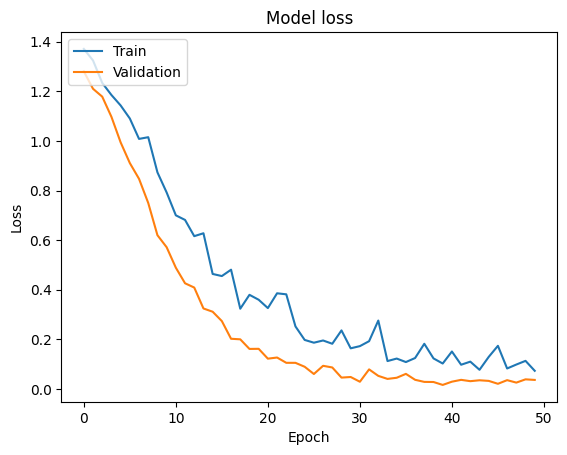

In [26]:
# Visualize training vs validation loss
plt.figure()
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


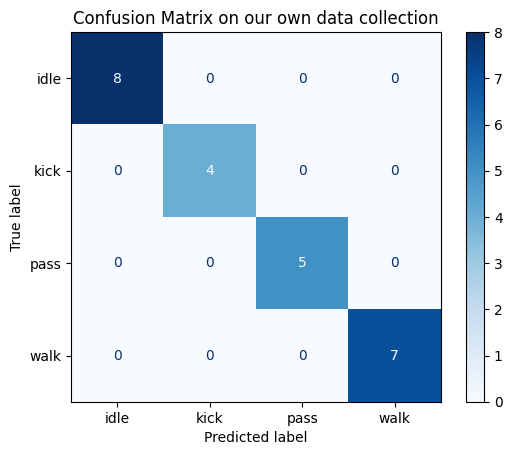

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00         8
        kick       1.00      1.00      1.00         4
        pass       1.00      1.00      1.00         5
        walk       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate the model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
ConfusionMatrixDisplay.from_predictions(predicted_classes, true_classes, display_labels=CLASSES.keys(), cmap=plt.cm.Blues)
plt.title('Confusion Matrix on our own data collection')
plt.show()
print(classification_report(true_classes, predicted_classes, target_names=CLASSES.keys()))

# Validating on unseen data

X_unseen shape: (40, 100, 18, 1), y_unseen shape: (40, 4)
Participant Geoffrey data shape: (100, 18, 1)
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


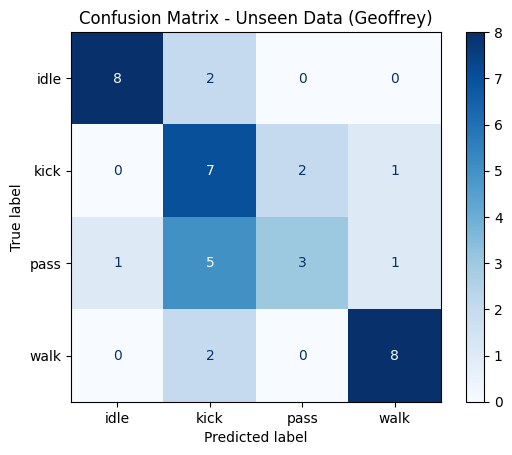

              precision    recall  f1-score   support

        idle       0.89      0.80      0.84        10
        kick       0.44      0.70      0.54        10
        pass       0.60      0.30      0.40        10
        walk       0.80      0.80      0.80        10

    accuracy                           0.65        40
   macro avg       0.68      0.65      0.65        40
weighted avg       0.68      0.65      0.65        40



In [28]:
data = np.empty((0, 101, 19))
participant = 'Geoffrey'
unseen_data = compile_data(participant)
data = np.append(data, unseen_data, axis=0)

# Shuffle the data
num_samples = data.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)
shuffled_data = data[indices]

# Separate features and labels
X_unseen = shuffled_data[:, 1:, :-1].astype(np.float32)
X_unseen = np.expand_dims(preprocess_data(X_unseen), axis=-1)
y_unseen = shuffled_data[:, 0, -1].reshape(-1, 1)
y_unseen = to_categorical(y_unseen.squeeze(), num_classes=4)

print(f"X_unseen shape: {X_unseen.shape}, y_unseen shape: {y_unseen.shape}")
print(f"Participant {participant} data shape: {X_unseen[0].shape}")

# Evaluate the model on unseen data
predictions_unseen = model.predict(X_unseen, batch_size=1)
predicted_classes_unseen = np.argmax(predictions_unseen, axis=1)
true_classes_unseen = np.argmax(y_unseen, axis=1)
ConfusionMatrixDisplay.from_predictions(true_classes_unseen, predicted_classes_unseen, display_labels=CLASSES.keys(), cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Unseen Data ({participant})')
plt.show()
print(classification_report(true_classes_unseen, predicted_classes_unseen, target_names=CLASSES.keys()))

In [22]:
# Predict 1 value to emulate Real-time
sample = X_unseen[0]
print(f"Sample shape: {sample.shape}")

# Reshape the sample to match the input shape of the model
sample = sample.reshape(1, 100, 18, 1)
print(f"Sample reshaped: {sample.shape}")

prediction = model.predict(sample, batch_size=1)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {predicted_class}, Label: {REVERSE_CLASSES[predicted_class]}")

Sample shape: (100, 18, 1)
Sample reshaped: (1, 100, 18, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 0, Label: idle


In [23]:
## Export Model to ONNX
import tf2onnx
import onnx

import os
import shutil


# Export Tensofrlow style model
model.save('SavedModels/2sTimeWindow_CNN_model.keras')


# Time-series implementation
- Split the data into timeseries and pick windows of certain sizes to complete classifications. 

X_train_window shape: (96, 10, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 10, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2737 - loss: 1.3913 - val_accuracy: 0.3500 - val_loss: 1.3336
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2483 - loss: 1.3961 - val_accuracy: 0.5500 - val_loss: 1.3058
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2922 - loss: 1.3529 - val_accuracy: 0.8000 - val_loss: 1.2766
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3963 - loss: 1.3291 - val_accuracy: 0.5500 - val_loss: 1.2506
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2267 - loss: 1.3112 - val_accuracy: 0.6000 - val_loss: 1.2191
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3394 - loss: 1.2691 - val_accuracy: 0.6000 - val_loss: 1.1853
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5197 - loss: 1.1939 - val_accuracy: 0.6000 - val_loss: 1

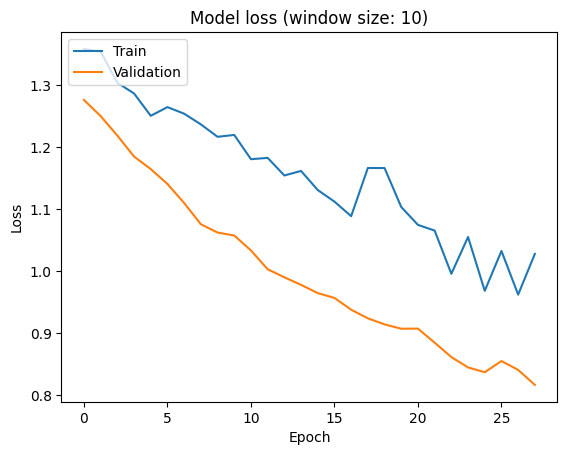

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Window size: 10


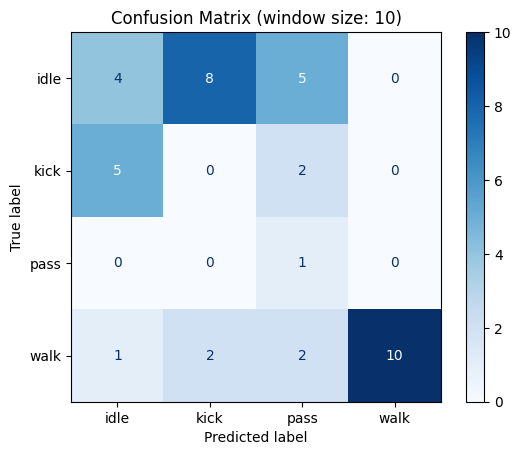

X_train_window shape: (96, 20, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 20, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2793 - loss: 1.3992 - val_accuracy: 0.4500 - val_loss: 1.3430
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2390 - loss: 1.3438 - val_accuracy: 0.6500 - val_loss: 1.2948
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4010 - loss: 1.3252 - val_accuracy: 0.6500 - val_loss: 1.2648
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4014 - loss: 1.3338 - val_accuracy: 0.6000 - val_loss: 1.2427
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4637 - loss: 1.2999 - val_accuracy: 0.6000 - val_loss: 1.2050
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5164 - loss: 1.2497 - val_accuracy: 0.6000 - val_loss: 1.1689
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3964 - loss: 1.2418 - val_accuracy: 0.6000 - val_loss: 1

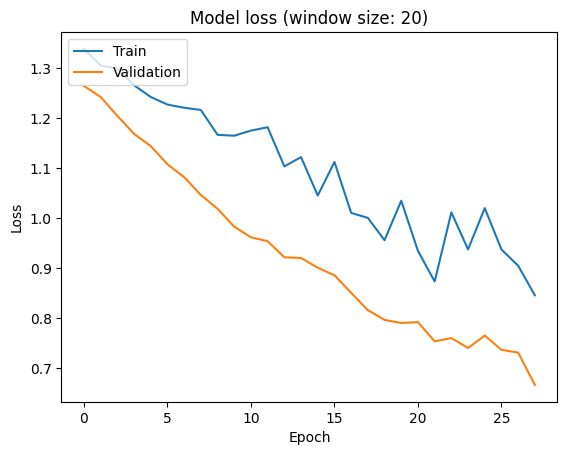

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Window size: 20


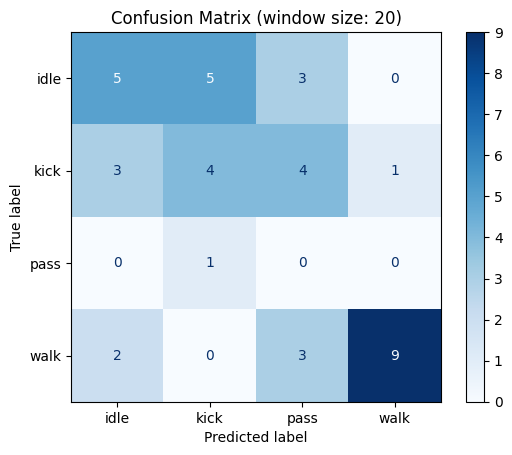

X_train_window shape: (96, 30, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 30, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1907 - loss: 1.4760 - val_accuracy: 0.4000 - val_loss: 1.2899
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4098 - loss: 1.3353 - val_accuracy: 0.4000 - val_loss: 1.2509
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4026 - loss: 1.2943 - val_accuracy: 0.4500 - val_loss: 1.2240
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4905 - loss: 1.2556 - val_accuracy: 0.4500 - val_loss: 1.1974
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4237 - loss: 1.2817 - val_accuracy: 0.4500 - val_loss: 1.1655
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3720 - loss: 1.3129 - val_accuracy: 0.4500 - val_loss: 1.1536
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4083 - loss: 1.2822 - val_accuracy: 0.4500 - val_loss: 1

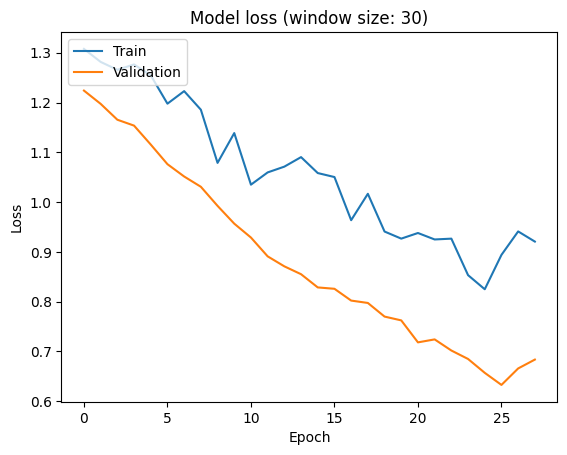

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Window size: 30


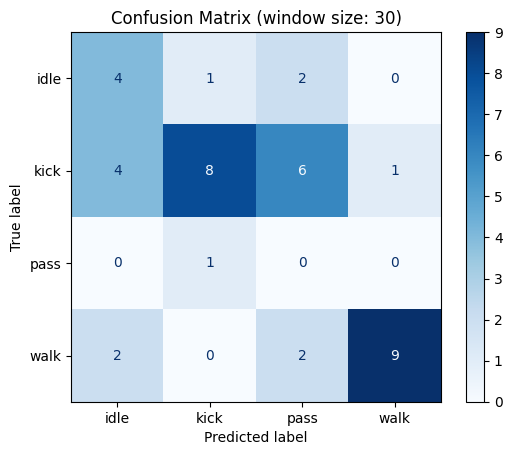

X_train_window shape: (96, 40, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 40, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2879 - loss: 1.3774 - val_accuracy: 0.5000 - val_loss: 1.3172
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2865 - loss: 1.3447 - val_accuracy: 0.6500 - val_loss: 1.2809
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3075 - loss: 1.3860 - val_accuracy: 0.5500 - val_loss: 1.2687
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4194 - loss: 1.2703 - val_accuracy: 0.7000 - val_loss: 1.2111
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5617 - loss: 1.2408 - val_accuracy: 0.7000 - val_loss: 1.1902
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4413 - loss: 1.2492 - val_accuracy: 0.6500 - val_loss: 1.1370
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4933 - loss: 1.1774 - val_accuracy: 0.7500 - val_loss: 

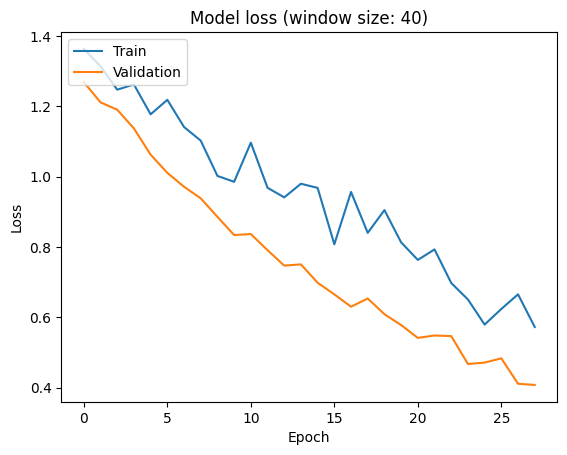

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Window size: 40


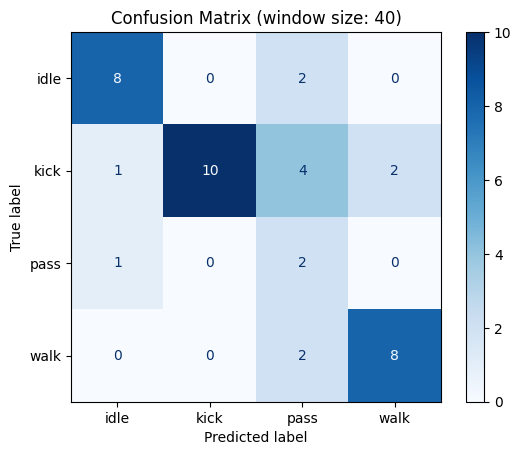

X_train_window shape: (96, 50, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 50, 18, 1), y_test shape: (40, 4)
Epoch 1/30


KeyboardInterrupt: 

In [24]:
def select_time_window(X, window_size):
    # Select only the window_size amount of points from the start of each sample
    return X[:, :window_size, :]
    
# 50Hz sampling rate, 100 samples = 2 seconds
# 25 samples = 0.5 seconds
window_sizes = [10, 20, 30, 40, 50, 75, 100]
accuracys = []
for window_size in window_sizes:
    X_train_window = select_time_window(X_train, window_size)
    X_test_window = select_time_window(X_unseen, window_size)
    y_test = y_unseen
    
    # Create the model
    model = create_cnn(num_classes=4)

    # Print the shapes of the data
    print(f"X_train_window shape: {X_train_window.shape}, y_train shape: {y_train.shape}, X_test_window shape: {X_test_window.shape}, y_test shape: {y_test.shape}")
    # Train the model
    history = model.fit(X_train_window, y_train, epochs=30, batch_size=4, validation_split=0.2)

    # Visualize training vs validation loss
    plt.figure()
    plt.plot(history.history['loss'][2:])
    plt.plot(history.history['val_loss'][2:])
    plt.title(f'Model loss (window size: {window_size})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Evaluate the model
    predictions = model.predict(X_test_window)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Track Accuracy
    accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
    accuracys.append(accuracy)
    
    print(f"Window size: {window_size}")
    ConfusionMatrixDisplay.from_predictions(predicted_classes, true_classes, display_labels=CLASSES.keys(), cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (window size: {window_size})')
    plt.show()

# Plot the accuracies by window size
plt.figure()
plt.plot(window_sizes, accuracys)
plt.title('Accuracy by window size')
plt.ylabel('Accuracy')
plt.xlabel('Window size')
plt.xticks(window_sizes)
plt.show()